### Import all packages

In [227]:
# from hw2
import pydub
from pydub import AudioSegment
import pydub
from pydub.playback import play
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import sleep
import scipy.io.wavfile as wav
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [228]:
import numpy as np
import pandas as pd
import torch

### Preparing the dataset

In [229]:
downloaded_files = glob(f"./data/audios/*.mp3")
num_downloaded_files = len(downloaded_files)

In [230]:
dev = pd.read_csv("./data/tsvs/dev.tsv", sep="\t")
train = pd.read_csv("./data/tsvs/train.tsv", sep="\t")
test = pd.read_csv("./data/tsvs/test.tsv", sep="\t")
validated = pd.read_csv("./data/tsvs/validated.tsv", sep="\t")
invalidated = pd.read_csv("./data/tsvs/invalidated.tsv", sep="\t")

splits = {
    "dev": dev,
    "train": train, 
    "test": test,
    "validated": validated,
    "invalidated": invalidated
}

#### Fix the paths

In [231]:
prefix = "./data/audios/"
for key in splits:
    splits[key]['path'] = prefix + splits[key]['path'].astype(str)

#### Drop the rows with NaN accent values

In [232]:
for key in splits:
    print(len(splits[key]))

15531
232975
15531
218400
124820


In [233]:
for key in splits:
    splits[key].dropna(axis=0, subset=["accent"], inplace=True)
    print(len(splits[key]))

2100
135391
1398
46169
46728


#### Drop the rows yet to be validated

In [234]:
train.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accent'],
      dtype='object')

In [235]:
columns = ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent']

# https://stackoverflow.com/questions/26921943/pandas-intersection-of-two-data-frames-based-on-column-entries
train_validated = pd.merge(train, validated, how='inner', on=columns)
test_validated = pd.merge(test, validated, how='inner', on=columns)
dev_validated = pd.merge(dev, validated, how='inner', on=columns)

In [236]:
print(f"The overall dataset has {len(train_validated)} training, {len(test_validated)} test and {len(dev_validated)} dev validated audio files.")

The overall dataset has 14480 training, 1398 test and 2100 dev validated audio files.


#### Lets look at the overall data

In [237]:
# visualize categorical data https://www.datacamp.com/community/tutorials/categorical-data
def visualize_categorical_distribution(pd_series, title="Plot", ylabel='Number of Samples', xlabel='Accent', figsize=None):
    digit_counts = pd_series.value_counts()
    sns.set(style="darkgrid")
    if figsize is None:
        sns.set(rc={'figure.figsize':(10,6)})
    else:
        sns.set(rc={'figure.figsize':figsize})
    sns.barplot(digit_counts.index, digit_counts.values, alpha=0.9)
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.show()

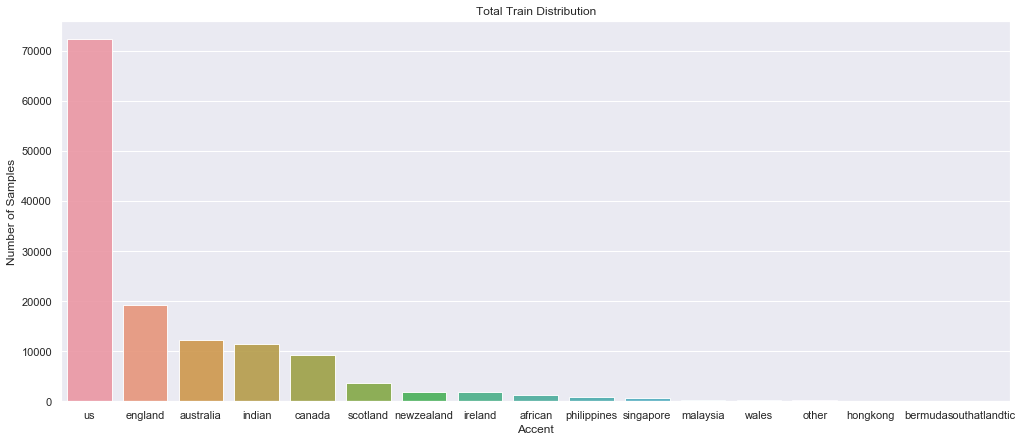

In [238]:
visualize_categorical_distribution(splits["train"]["accent"], "Total Train Distribution", figsize=(17,7))

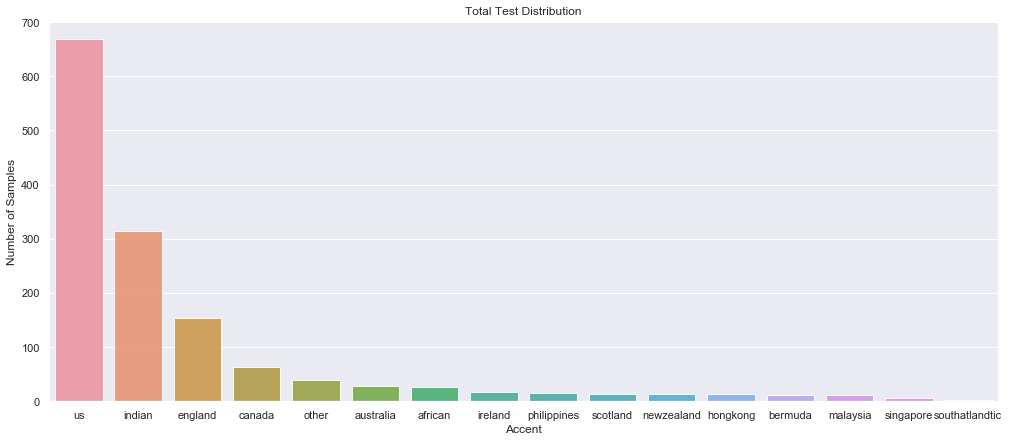

In [239]:
visualize_categorical_distribution(splits["test"]["accent"], "Total Test Distribution", figsize=(17,7))

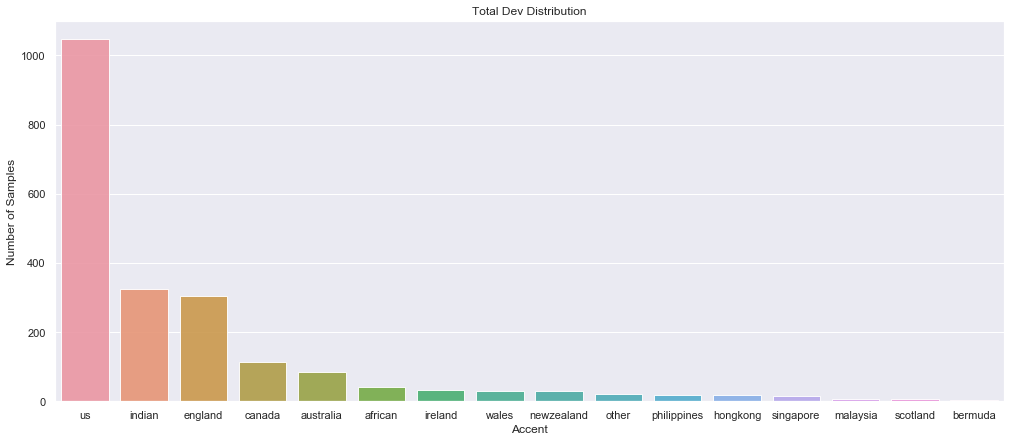

In [240]:
visualize_categorical_distribution(splits["dev"]["accent"], "Total Dev Distribution", figsize=(17,7))

Lets look at some other attributes...

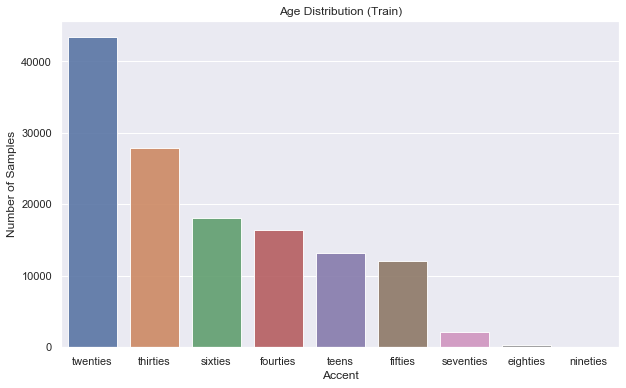

In [241]:
visualize_categorical_distribution(splits["train"]["age"], "Age Distribution (Train)")

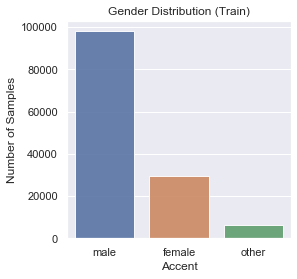

In [242]:
visualize_categorical_distribution(splits["train"]["gender"], "Gender Distribution (Train)", figsize=(4,4))

#### What about the overall validated data?

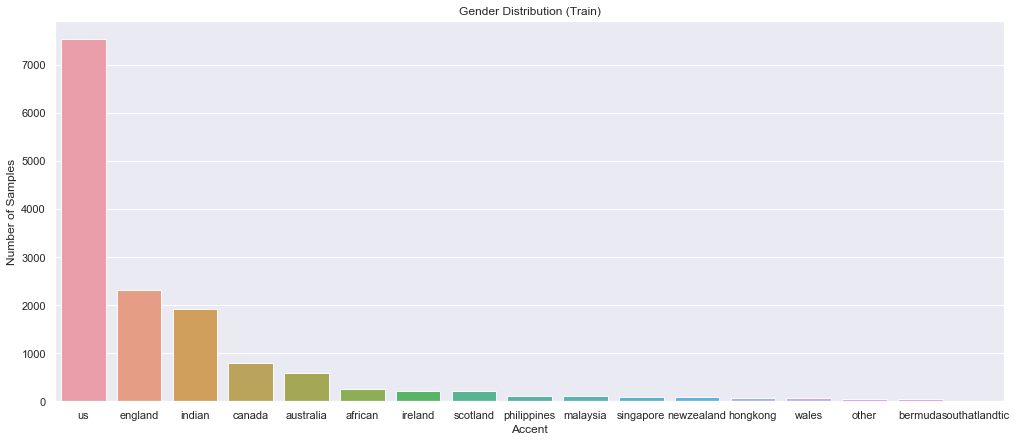

In [243]:
visualize_categorical_distribution(train_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

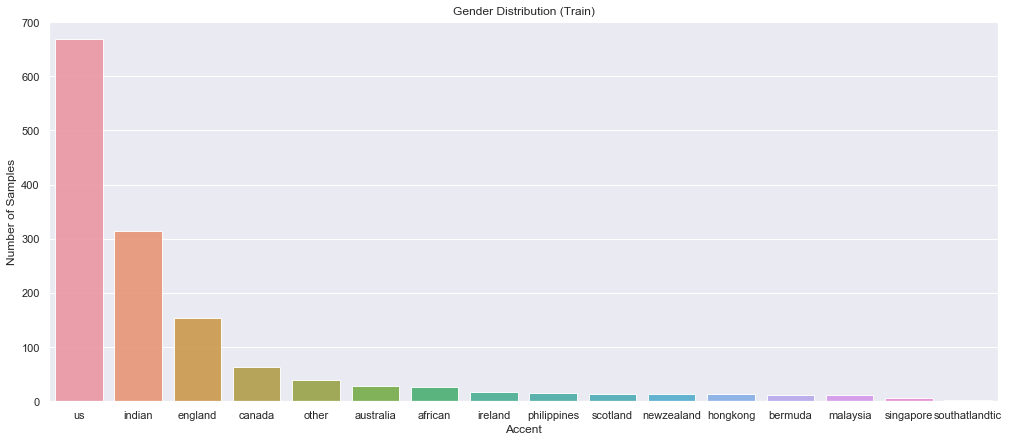

In [244]:
visualize_categorical_distribution(test_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

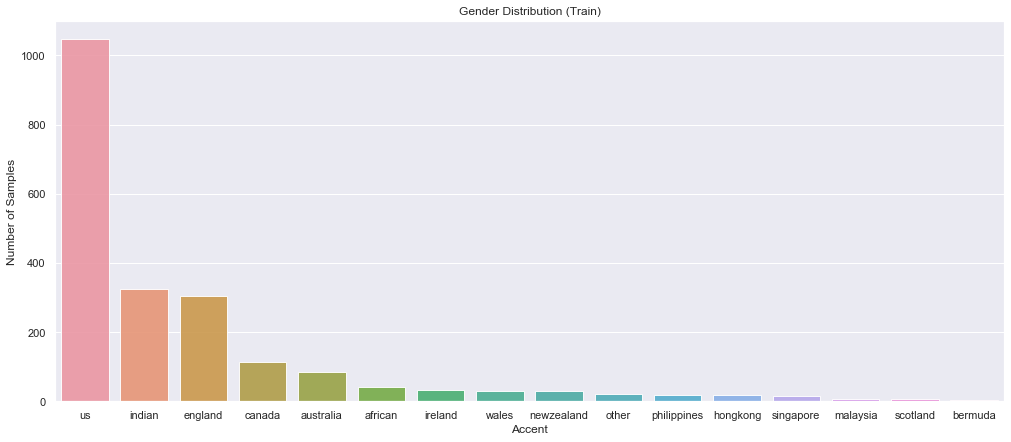

In [245]:
visualize_categorical_distribution(dev_validated["accent"], "Gender Distribution (Train)", figsize=(17,7))

#### Choose the data we've actually downloaded

In [246]:
for key in splits:
    splits[key] = splits[key][splits[key]["path"].isin(downloaded_files)]
    print(len(splits[key]))

2
414
2
41
76


#### Make sure speaker independent and validated

In [247]:
len(splits['train'][splits['train']["client_id"].isin(splits['test']['client_id'])])

0

In [248]:
len(splits['train'][splits['train']["client_id"].isin(splits['dev']['client_id'])])

0

In [249]:
num_train = len(splits['train'][splits['train']["client_id"].isin(splits['validated']['client_id'])])
num_test = len(splits['test'][splits['test']["client_id"].isin(splits['validated']['client_id'])])
num_dev = len(splits['dev'][splits['dev']["client_id"].isin(splits['validated']['client_id'])])

print(f"Wow, we only end up with {num_train} training, {num_test} test and {num_dev} dev audio files from the {num_downloaded_files} files we started with!")

Wow, we only end up with 37 training, 2 test and 2 dev audio files from the 900 files we started with!


## For the purposes of this toy example we forgoe using only the validated clips and assume all clips are good. 

#### Lets take a look at some of our downloaded data

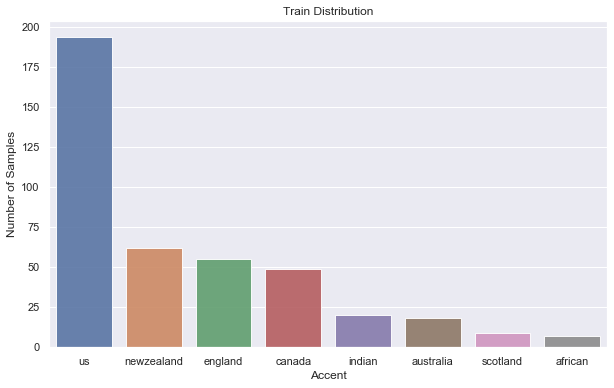

In [250]:
visualize_categorical_distribution(splits["train"]["accent"], "Train Distribution")

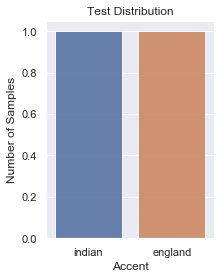

In [251]:
visualize_categorical_distribution(splits["test"]["accent"], "Test Distribution", figsize=(3,4))

Lets play some audio files

In [252]:
def play_mp3_from_path(relative_path):
    """plays mp3 located at provided relative path, returns the audio segment"""
    a = pydub.AudioSegment.from_mp3(relative_path)
    # test that it sounds right (requires ffplay, or pyaudio):
    play(a)
    return a

In [ ]:
# pick 4 random audio files from first 10
paths = np.random.choice(splits["train"]["path"][:10], size=4)

for path in paths:
    play_mp3_from_path(path)

# Yikes... That is a bad distribution.

#### Lets start preprocessing our actual audio files to the dataset

Some useful functions:

In [272]:
from utils import *

##### Extract the audio files, remove leading silence, and silent clips...

In [255]:
train = splits["train"]

In [256]:
# Remove silent clips
drop_idxs = train[train['path'].apply(detect_leading_silence_filepath) >= train['path'].apply(length_of_file)-1].index
train = train.drop(drop_idxs)

In [260]:
# Zero pad to normalize length
downloaded_audios = [pydub.AudioSegment.from_mp3(f) for f in train['path']]

In [265]:
max_audio_length = np.max([len(sample) for sample in downloaded_audios])
print(f"max audio length is {max_audio_length / 1000} seconds")

max audio length is 10.416 seconds


In [267]:
padded_audios = [zero_pad_in_end(audio, max_audio_length) for audio in downloaded_audios]

In [269]:
audio_embeddings = pd.DataFrame({
    'label': train['accent'], 
    'mfcc': np.array([extract_mfcc(audio) for audio in downloaded_audios]),
    'mfb': np.array([extract_mfb(audio) for audio in downloaded_audios]),
    'mfcc_padded': np.array([extract_mfcc(audio) for audio in padded_audios]),
    'mfb_padded': np.array([extract_mfb(audio) for audio in padded_audios])
})

In [270]:
audio_embeddings.head()

,label,mfcc,mfb,mfcc_padded,mfb_padded
2983,england,"[[11.477419668642064, 19.60129823848928, 15.47...","[[10.603478072985322, 9.921344840603071, 8.993...","[[11.477419668642064, 19.60129823848928, 15.47...","[[10.603478072985322, 9.921344840603071, 8.993..."
5063,england,"[[15.076739250592162, -17.578075150339394, -17...","[[7.828453007195243, 6.435905874179174, 8.5556...","[[15.076739250592162, -17.578075150339394, -17...","[[7.828453007195243, 6.435905874179174, 8.5556..."
13314,us,"[[9.991541885480853, 24.89319712616629, 9.7707...","[[8.47957537897799, 8.532251250598659, 8.73649...","[[9.991541885480853, 24.89319712616629, 9.7707...","[[8.47957537897799, 8.532251250598659, 8.73649..."
15873,canada,"[[12.096890491646878, 0.07845821269638574, -26...","[[6.542801499745751, 5.762531860080152, 6.2661...","[[12.096890491646878, 0.07845821269638574, -26...","[[6.542801499745751, 5.762531860080152, 6.2661..."
20306,england,"[[10.555789096135287, 10.810689636665122, -11....","[[8.19217792824229, 6.469158102406477, 5.84649...","[[10.555789096135287, 10.810689636665122, -11....","[[8.19217792824229, 6.469158102406477, 5.84649..."


In [217]:
audio_embeddings['mfcc'][5063].shape, audio_embeddings['mfb'][2983].shape, 

((976, 13), (1339, 26))

#TODO: Plot some filterbanks and mfccs

#TODO: Constant size features for CNN

#### TODO:: Create a validation set?

#### TODO: Creating our Toy Models

##### Toy CNN

In [ ]:
train['path'][2983]

In [ ]:
sound = pydub.AudioSegment.from_mp3(train['path'][2983])
play(sound)

In [ ]:
sound.frame_rate

##### Toy LSTM

In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html